In [2]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

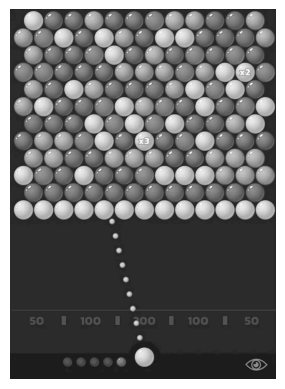

In [3]:
# Carga la imagen
ballscol = cv2.imread('../../IMAGES/practica2.1_kmeans_2.png', 1)
ballsc = cv2.cvtColor(ballscol, cv2.COLOR_BGR2RGB)

balls = cv2.imread('../../IMAGES/practica2.1_kmeans_2.png', 0)

plt.axis("off")
plt.imshow(balls, cmap='gray')

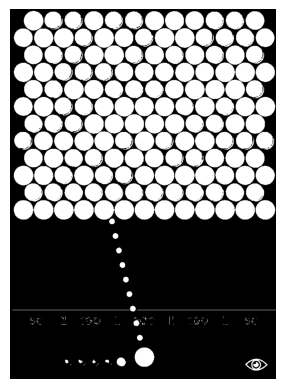

In [4]:
# Binarizacion
_, imgBin = cv2.threshold(balls, 84, 255, cv2.THRESH_BINARY)

plt.axis("off")
plt.imshow(imgBin, cmap='gray')

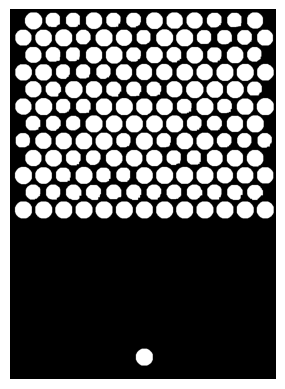

In [5]:
# Erosion y dilatacion
kernel = np.ones((5,5), np.uint8)

img_erosion = cv2.erode(imgBin, kernel, iterations=4)
img_dilation = cv2.dilate(img_erosion, kernel, iterations=3)


plt.axis("off")
plt.imshow(img_dilation, cmap='gray')

(963, 693, 3)


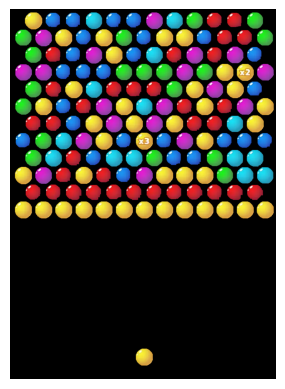

In [6]:
# Mascara aplicada a imagen a color
cv2.imwrite("../../IMAGES/piv.jpg", img_dilation)
img_dilation2 = cv2.imread('../../IMAGES/piv.jpg', 1)

masked3 = cv2.bitwise_and(img_dilation2, ballsc)

print(masked3.shape)

plt.axis("off")
plt.imshow(masked3, cmap='gray')

(192, 138, 3)


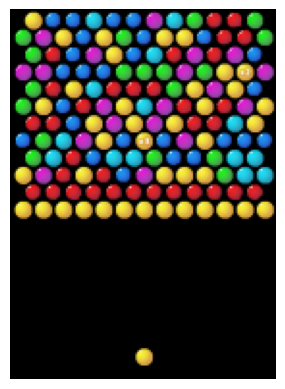

In [7]:
# Redimensionar la imagen (la original es muy graaaande)
escala = 20

alto = int(masked3.shape[0]*escala/100)
ancho = int(masked3.shape[1]*escala/100)

newdim = (ancho,alto)

new = cv2.resize(masked3, newdim, interpolation=cv2.INTER_AREA)

print(new.shape)

plt.axis("off")
plt.imshow(new, cmap='gray')

In [8]:
# Separar las imagenes en 3 canales
B, G, R = cv2.split(new)

# Convertir cada canal en arreglo
ArrayR = np.asarray(R)
ArrayG = np.asarray(G)
ArrayB = np.asarray(B)

# Vectorizar cada canal
vectorR = ArrayR.flatten()
vectorG = ArrayG.flatten()
vectorB = ArrayB.flatten()


print(vectorR)
print(vectorR.shape)

[0 0 0 ... 0 0 0]
(26496,)


In [9]:
# Dataframe de cada canal de la imagen
column_nameR = ["R"]
column_nameG = ["G"]
column_nameB = ["B"]

data_R = pd.DataFrame(vectorR, columns=column_nameR)
data_G = pd.DataFrame(vectorG,columns=column_nameG)
data_B = pd.DataFrame(vectorB,columns=column_nameB)

result = pd.concat([data_R, data_G, data_B],axis=1)

result

,R,G,B
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
26491,0,0,0
26492,0,0,0
26493,0,0,0
26494,0,0,0


In [10]:
# Numero de clusters y caracteristicas (R,G,B)
K=6

c1 = result.iloc[:,0]
c2 = result.iloc[:,1]
c3 = result.iloc[:,2]

In [11]:
# Rangos en los que se encuentran los valores de cada canal
zero_min=np.min(c1)
zero_max=np.max(c1)

one_min=np.min(c2)
one_max=np.max(c2)

two_min=np.min(c3)
two_max=np.max(c3)

print(int(zero_min),int(zero_max))

0 249


In [12]:
# Rndomizar centroides
np.random.seed(1500)

In [13]:
# Posiciones de los k centroides
mu=[]
for i in range(0,K):
    zeros=np.random.randint(zero_min,zero_max)
    ones=np.random.randint(one_min,one_max)
    twos=np.random.randint(two_min,two_max)
    
    mu.append([zeros,ones,twos])

mu

[[19, 75, 193],
 [125, 110, 194],
 [169, 143, 147],
 [208, 152, 234],
 [81, 123, 135],
 [55, 49, 231]]

In [14]:
# Dataset con 6 caracteristicas
r=np.zeros(result.shape[0]*K).reshape(result.shape[0],K)
pd.DataFrame(r).head()

,0,1,2,3,4,5
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# Distorsion
plot_counter=0
J_plot=[]

for i in range(1,10): # Realizar el proceso máximo 10 veces
    J=0 # Medida de distorsión
    
    # Recorrer todos los elementos de la base de datos para ir guardando la clase a la que pertenece
    for n in range(0,result.shape[0]): 
        x=np.array(result.iloc[n,0:4])
        mins=[]

        for k in range(0,K):
            distance=np.linalg.norm(x-mu[k]) # Cálculo de distancia euclidiana
            mins.append(distance**2) # Guardar las distancias para despues elegir la menor

        k_r=np.argmin(np.array(mins)) # Se compara el valor minimo para obtener la posicion correspondiente a la clase
        r[n,k_r]=1 # Asignación de clases a cada elemento en ""r"
    
    # Calcula el valor de la medida de distorsión y guarda el valor de J en una lista para saber su valor actual y el previo
    for n in range(0,result.shape[0]):
        for k in range(0,K):
            distance=np.linalg.norm(x-mu[k])
            J=r[n,k]*(distance**2)+J
    J_plot.append(J)

    # Actualizar los centroides dentro de mu[]
    for k in range(0,K):
        count_1,count_2=0,0
        for n in range(0,result.shape[0]):
            x=np.array(result.iloc[n,0:4])
            count_1=r[n,k]*x+count_1
            count_2=r[n,k]+count_2
        mu[k]=count_1/count_2
        
    print(J)
    
    # Termina el ciclo si J no tiene un cambio considerable con su valor previo
    if i>1 and abs(J-J_prev)<0.5:
        break
    J_prev=J
    plot_counter=1+plot_counter

1226557808.0
581532723.6016746
564720537.6183817
596400751.7950566
601535281.2912267
603957393.1043701
605715544.8378537
606860055.5636076
607429221.5278478


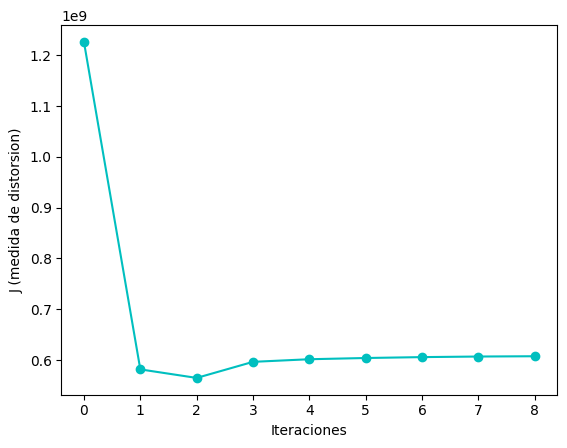

In [16]:
# Medida de distorsion
import matplotlib.pyplot as plt

plt.plot(J_plot,linestyle='-', marker='o',color='c')
plt.ylabel('J (medida de distorsion)')
plt.xlabel('Iteraciones')
plt.show()

In [17]:
# Metodo del codo calculando la distancia intracluster en 10 centroides

J_plotF=[]

for cen in range (10):
    mu=[]
    for i in range(0,cen+1):
        zeros=np.random.randint(zero_min,zero_max)
        ones=np.random.randint(one_min,one_max)
        twos=np.random.randint(two_min,two_max)
        
        mu.append([zeros,ones,twos])

    #print(mu)
    
    
    plot_counter=0
    J_plot=[]
    
    
    for i in range(1,10): # Realizar el proceso máximo 10 veces
        J=0 # Medida de distorsión
        
        # Recorrer todos los elementos de la base de datos para ir guardando la clase a la que pertenece
        for n in range(0,result.shape[0]): 
            x=np.array(result.iloc[n,0:4])
            mins=[]
            for k in range(0,cen):
                distance=np.linalg.norm(x-mu[cen]) # Cálculo de distancia euclidiana
                

        # Calcula el valor de la medida de distorsión y guarda el valor de J en una lista para saber su valor actual y el previo
        for n in range(0,result.shape[0]):
            for k in range(0,K):
                distance=np.linalg.norm(x-mu[cen])
                J=r[n,k]*(distance**2)+J
        J_plot.append(J)
    
    J_plotF.append(max(J_plot))

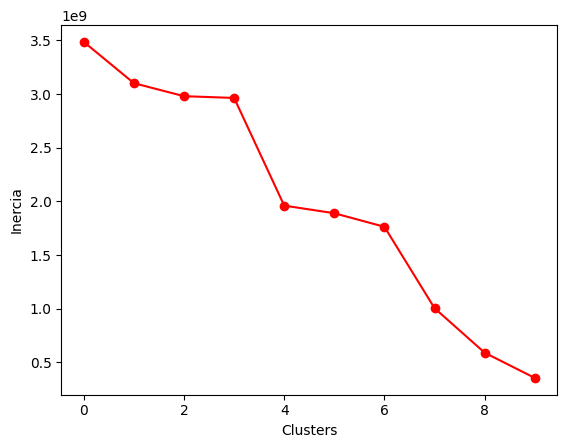

In [18]:
# Metodo del codo
J_plotF.sort(reverse=True)

plt.plot(J_plotF,linestyle='-', marker='o',color='r')
plt.ylabel('Inercia')
plt.xlabel('Clusters')
plt.show()

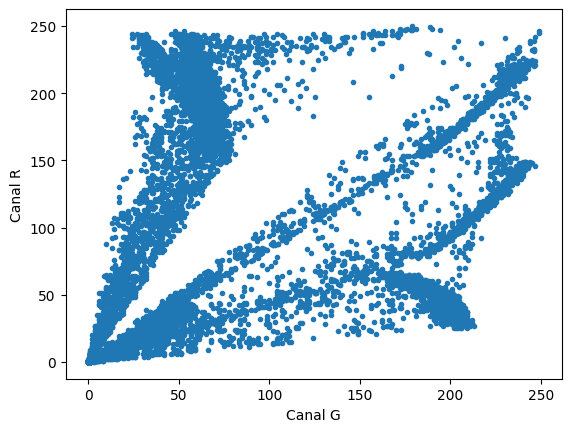

In [19]:
# Grafica en 2D (canal R y G)
plt.scatter(c1,c2,marker='.')
plt.ylabel('Canal R')
plt.xlabel('Canal G')
plt.show()

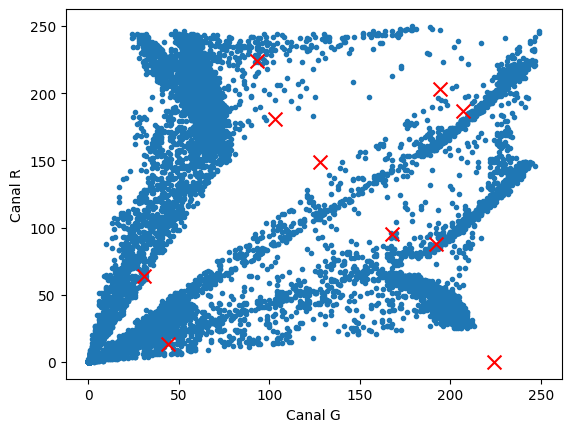

,0,1,2
0,31,64,193
1,168,95,16
2,44,13,75
3,93,224,25
4,192,88,90
5,194,203,228
6,128,149,30
7,224,0,146
8,207,187,79
9,103,181,137


In [20]:
# Grafica en 2D con clusters
mu=pd.DataFrame(mu)
plt.scatter(c1,c2,marker='.')
plt.scatter(mu[0],mu[1],s=100,marker='x',color='red')
plt.ylabel('Canal R')
plt.xlabel('Canal G')
plt.show()

mu

In [21]:
# Dataset de cada dato con su clase correspondiente
r_new=[]
for row in r:
    r_new.append(np.argmax(row)+1)

nueva = pd.DataFrame(r_new)

resultado = pd.concat([result,nueva],axis=1)

resultado

,R,G,B,0
0,0,0,0,5
1,0,0,0,5
2,0,0,0,5
3,0,0,0,5
4,0,0,0,5
...,...,...,...,...
26491,0,0,0,5
26492,0,0,0,5
26493,0,0,0,5
26494,0,0,0,5


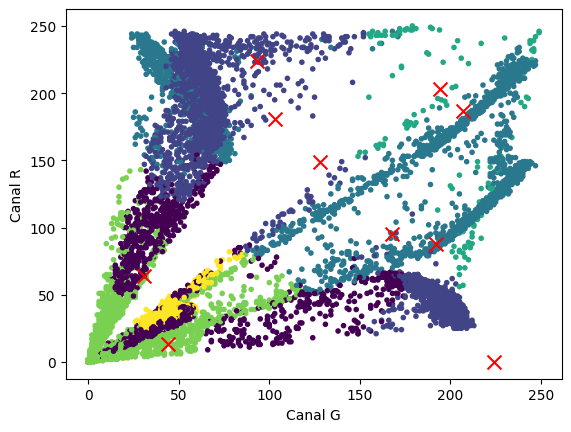

In [22]:
# Graficar en 2D con asigancion de clases
plt.scatter(c1,c2,c=resultado.iloc[:,3],marker='.')
plt.scatter(mu[0],mu[1],s=100,marker='x',color='red')
plt.ylabel('Canal R')
plt.xlabel('Canal G')
plt.show()

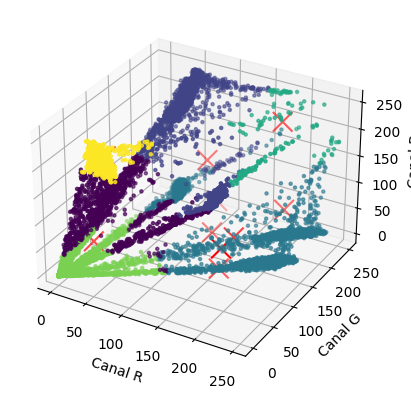

In [23]:
# Graficar en 3D
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x1 =c1
y1 =c2
z1 =c3

x2=mu[0]
y2=mu[1]
z2=mu[2]

ax.scatter(x1, y1, z1, c=resultado.iloc[:,3], marker='.')
ax.scatter(x2, y2, z2, c='red', s=200, marker='x')

ax.set_xlabel('Canal R')
ax.set_ylabel('Canal G')
ax.set_zlabel('Canal B')

plt.show()

In [24]:
# Funcion para calcular la distancia entre los pixeles mas cercanos a un color
def distanciaColor(pixelr, r, pixelg, g, pixelb, b):
    return np.sqrt((pixelr - r) ** 2 + (pixelg - g) ** 2 + (pixelb - b) ** 2)

In [25]:
# Funcion para obtener los pixeles mas cercanos a un color
def getUsefulPixel(red, green, blue, color, accepted):
    
    dim = red.shape # Tamaño de la imagen vectorizada
    filteredImage = np.zeros(dim) # Nuevo vector

    # Utilizar divide y vencerás
    def divide_and_conquer(start, end):
        if start >= end:
            distance = distanciaColor(color[0], red[start], color[1], green[start], color[2], blue[start])
            if distance < accepted:
                filteredImage[start] = 255
        else:
            mid = (start + end) // 2
            divide_and_conquer(start, mid)
            divide_and_conquer(mid + 1, end)

    divide_and_conquer(0, len(red) - 1)
    
    return filteredImage

In [26]:
#Funcion que obtiene los frames con el color deseado
def findColor(image, color, accepted):
    
    # Tamaño de la imagen
    wid, hght, canal = image.shape 
    
    # Recuperar canales
    red_channel = image[:, :, 0]
    green_channel = image[:, :, 1]
    blue_channel = image[:, :, 2]

    # Vectorizar cada canal
    redV = red_channel.flatten()
    greenV = green_channel.flatten()
    blueV = blue_channel.flatten()

    # Pasar los canales vectorizados a la funcion
    filteredImage = getUsefulPixel(redV, greenV, blueV, color, accepted) # Obtener el vector
    filteredImage = np.reshape(filteredImage, (wid, hght))

    return filteredImage

In [27]:
def area_color(img, img_bin):
    newImage = np.zeros_like(img)

    wid, hght, canal = img.shape
    for i in range(wid):
        for j in range(hght):
            if(img_bin[i,j] == 255):
                newImage[i,j,0] = 255
                newImage[i,j,1] = 255
                newImage[i,j,2] = 255
    return newImage

He encontrado 41 objetos


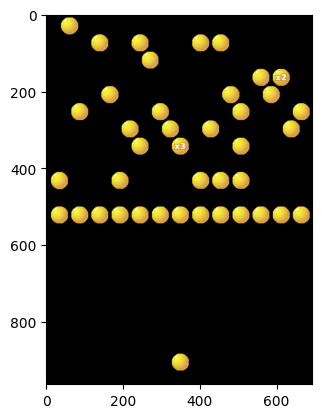

In [28]:
# Color al que queremos aproximar
# Amarillo
colorDetected = np.array([243, 224, 63])
# Rango de color aceptado
acceptedColor = 120

filteredImage = findColor(masked3, colorDetected, acceptedColor)
mascara = area_color(masked3, filteredImage)

msk1 = cv2.erode(mascara, kernel, iterations=1)
msk2 = cv2.dilate(msk1, kernel, iterations=3)

juego = cv2.bitwise_and(msk2, masked3)
plt.imshow(juego)


# Convertimos a escala de grises
gris = cv2.cvtColor(juego, cv2.COLOR_BGR2GRAY)
 
# Aplicar suavizado Gaussiano
gauss = cv2.GaussianBlur(gris, (5,5), 0)
 
# Detectamos los bordes con Canny
canny = cv2.Canny(gauss, 50, 150)
 
# Buscamos los contornos
(contornos,_) = cv2.findContours(canny.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
 
# Mostramos el número de monedas por consola
print("He encontrado {} objetos".format(len(contornos)))

He encontrado 18 objetos


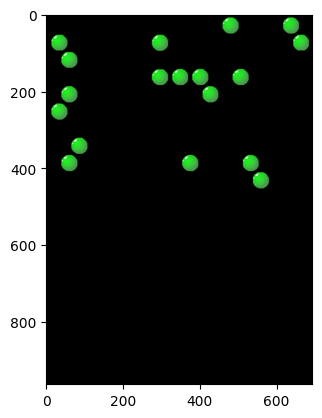

In [29]:
# Color al que queremos aproximar
# Verde
colorDetected = np.array([39, 231, 41])
# Rango de color aceptado
acceptedColor = 150

filteredImage = findColor(masked3, colorDetected, acceptedColor)
mascara = area_color(masked3, filteredImage)

msk1 = cv2.erode(mascara, kernel, iterations=1)
msk2 = cv2.dilate(msk1, kernel, iterations=4)

juego = cv2.bitwise_and(msk2, masked3)
plt.imshow(juego)


# Convertimos a escala de grises
gris = cv2.cvtColor(juego, cv2.COLOR_BGR2GRAY)
 
# Aplicar suavizado Gaussiano
gauss = cv2.GaussianBlur(gris, (5,5), 0)
 
# Detectamos los bordes con Canny
canny = cv2.Canny(gauss, 50, 150)
 
# Buscamos los contornos
(contornos,_) = cv2.findContours(canny.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
 
# Mostramos el número de monedas por consola
print("He encontrado {} objetos".format(len(contornos)))

He encontrado 26 objetos


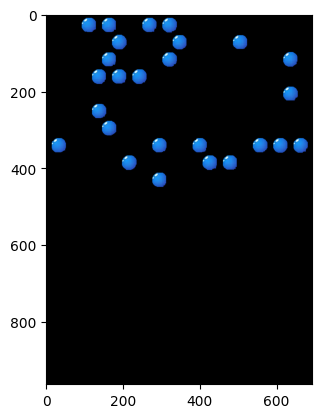

In [30]:
# Color al que queremos aproximar
# Azul cielo
colorDetected = np.array([39, 125, 228])
# Rango de color aceptado
acceptedColor = 40

filteredImage = findColor(masked3, colorDetected, acceptedColor)
mascara = area_color(masked3, filteredImage)

msk1 = cv2.erode(mascara, kernel, iterations=1)
msk2 = cv2.dilate(msk1, kernel, iterations=4)

juego = cv2.bitwise_and(msk2, masked3)
plt.imshow(juego)


# Convertimos a escala de grises
gris = cv2.cvtColor(juego, cv2.COLOR_BGR2GRAY)
 
# Aplicar suavizado Gaussiano
gauss = cv2.GaussianBlur(gris, (5,5), 0)
 
# Detectamos los bordes con Canny
canny = cv2.Canny(gauss, 50, 150)
 
# Buscamos los contornos
(contornos,_) = cv2.findContours(canny.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
 
# Mostramos el número de monedas por consola
print("He encontrado {} objetos".format(len(contornos)))

He encontrado 19 objetos


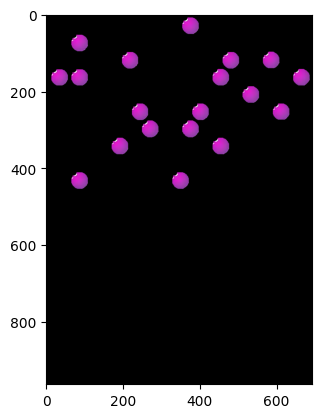

In [31]:
# Color al que queremos aproximar
# Rosa
colorDetected = np.array([209, 43, 205])
# Rango de color aceptado
acceptedColor = 100

filteredImage = findColor(masked3, colorDetected, acceptedColor)
mascara = area_color(masked3, filteredImage)

msk1 = cv2.erode(mascara, kernel, iterations=1)
msk2 = cv2.dilate(msk1, kernel, iterations=2)

juego = cv2.bitwise_and(msk2, masked3)
plt.imshow(juego)


# Convertimos a escala de grises
gris = cv2.cvtColor(juego, cv2.COLOR_BGR2GRAY)
 
# Aplicar suavizado Gaussiano
gauss = cv2.GaussianBlur(gris, (5,5), 0)
 
# Detectamos los bordes con Canny
canny = cv2.Canny(gauss, 50, 150)
 
# Buscamos los contornos
(contornos,_) = cv2.findContours(canny.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
 
# Mostramos el número de monedas por consola
print("He encontrado {} objetos".format(len(contornos)))

He encontrado 14 objetos


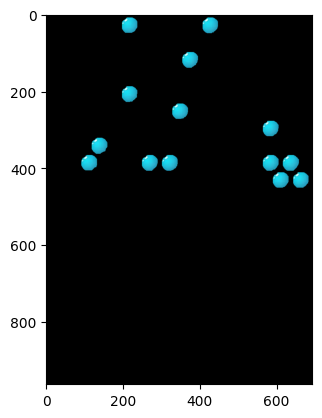

In [32]:
# Color al que queremos aproximar
# Cyan
colorDetected = np.array([31, 213, 236])
# Rango de color aceptado
acceptedColor = 60

filteredImage = findColor(masked3, colorDetected, acceptedColor)
mascara = area_color(masked3, filteredImage)

msk1 = cv2.erode(mascara, kernel, iterations=1)
msk2 = cv2.dilate(msk1, kernel, iterations=3)

juego = cv2.bitwise_and(msk2, masked3)
plt.imshow(juego)


# Convertimos a escala de grises
gris = cv2.cvtColor(juego, cv2.COLOR_BGR2GRAY)
 
# Aplicar suavizado Gaussiano
gauss = cv2.GaussianBlur(gris, (5,5), 0)
 
# Detectamos los bordes con Canny
canny = cv2.Canny(gauss, 50, 150)
 
# Buscamos los contornos
(contornos,_) = cv2.findContours(canny.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
 
# Mostramos el número de monedas por consola
print("He encontrado {} objetos".format(len(contornos)))

He encontrado 33 objetos


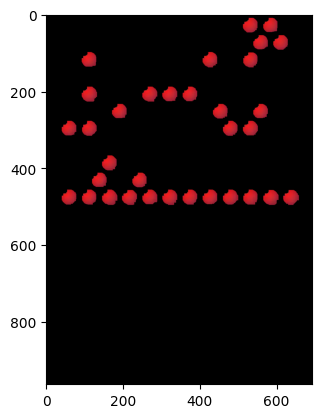

In [33]:
# Color al que queremos aproximar
# Rojo
colorDetected = np.array([216, 41, 43])
# Rango de color aceptado
acceptedColor = 90

filteredImage = findColor(masked3, colorDetected, acceptedColor)
mascara = area_color(masked3, filteredImage)

msk1 = cv2.erode(mascara, kernel, iterations=1)
msk2 = cv2.dilate(msk1, kernel, iterations=1)

juego = cv2.bitwise_and(msk2, masked3)
plt.imshow(juego)


# Convertimos a escala de grises
gris = cv2.cvtColor(juego, cv2.COLOR_BGR2GRAY)
 
# Aplicar suavizado Gaussiano
gauss = cv2.GaussianBlur(gris, (5,5), 0)
 
# Detectamos los bordes con Canny
canny = cv2.Canny(gauss, 50, 150)
 
# Buscamos los contornos
(contornos,_) = cv2.findContours(canny.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
 
# Mostramos el número de monedas por consola
print("He encontrado {} objetos".format(len(contornos)))